___ 
# <span style="color:red">문제 1</span>
- #### 아래의 타이타닉 데이터셋을 이용하여 탐색적 분석을 실시하고, 결과를 해석하라.
- #### 데이터 : Titanic.CSV (변수: 12, 자료 수: 891개)
- #### 변수 : Survived(생존여부) – Survival (0 = No, 1 = Yes) 

### 문제풀이
    1. 데이터 불러오기
    2. 데이터 정의
    3. 결측치 검사 및 보정
    4. 파생변수 생성
    5. 데이터 간 상관관계 검사
    5. 대략적인 변수 선정
    6. 그래프 분석을 통한 데이터 분석
    7. 결론 서술

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 회귀분석
from statsmodels.formula.api import ols
# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# Scale 변환->표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler
# 평가함수
from statsmodels.tools.eval_measures import rmse
# jupyter notebook 사용 시 그래프 자동 출력 옵션
import matplotlib
import matplotlib.font_manager as fm
# 선형회귀모형
from sklearn.linear_model import LinearRegression

# 실행결과 경고메시지 출력 제외
warnings.filterwarnings('ignore')
matplotlib.rc("font", family = "NanumGothic")
matplotlib.rc('axes', unicode_minus=False)

In [2]:
# 데이터 불러오기
df_raw = pd.read_csv('/home/piai/Dayonizzang._.r/BigData 실습/Big Data 분석/titanic.csv', encoding='euc-kr')
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 데이터 정의
    - Survived : 생존여부
    - Pclass : 승객 등급
    - Name, Sex, Age : 이름, 성별, 나이
    - SlibSp : 함께 탑승한 형제, 배우자의 수
    - Parch : 함께 탑승한 자녀, 부모의 수
    - Ticket : 티켓 아이디
    - Fare : 티켓 요금 
    - Cabin : 객실 번호
    - Embarked : 승객이 탑승한 곳
    

In [3]:
# 결측치 체크, Cabin의 결측치는 687개, Embarked의 결측치는 2개로 나타난다.
df_raw.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# Name(이름)과 Ticket(티켓 아이디)는 생존여부와 연관없으므로 삭제한다.
df_raw = df_raw.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [5]:
# Cabin 변수는 결측치가 상당수를 차지하기에 열 자체를 삭제한다.
df_raw = df_raw.drop(['Cabin'], axis=1)

In [6]:
# Embarked 변수는 결측치가 2개 이므로 최빈값으로 채워준다.
freq_word = df_raw['Embarked'].dropna().mode()[0]
print("Embarked의 최빈값은 : %s" % freq_word)
df_raw['Embarked'].fillna(freq_word, inplace = True)

Embarked의 최빈값은 : S


In [7]:
print(df_raw['Embarked'].value_counts())

S    646
C    168
Q     77
Name: Embarked, dtype: int64


In [8]:
# null 값이 없어진 것을 알 수 있다.
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


### 파생변수 생성
    - 데이터를 들여다보면, ["SibSp"]와 ["Parch"]를 통해 함께 탄 가족구성원에 대한 정보를 유추할 수 있다.
    - 따라서 ["SibSp"]와 ["Parch"]의 조합을 통해 ["Family"]란 파생변수를 생성할 수 있다.
    - 파생변수에 사용된 두 변수는 삭제하고, 파생변수를 통해 데이터를 분석할 계획이다.
        - 변수를 삭제하는 이유는 선형성을 가지기에 오차율이 커지기 때문이다.

In [9]:
df_raw['Family'] = df_raw['SibSp'] + df_raw['Parch']
df_raw = df_raw.drop(['SibSp'], axis=1)
df_raw = df_raw.drop(['Parch'], axis=1)
df_raw['Family']

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Name: Family, Length: 891, dtype: int64

In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    object 
 6   Family    891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [11]:
df_raw.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


### 데이터 간 상관관계 검사
    - 총 6가지 항목과 생존여부 데이터에 대해서 상관성이 있는지 판별하기 위해 그래프를 통해 시각화한다.

3    491
1    216
2    184
Name: Pclass, dtype: int64


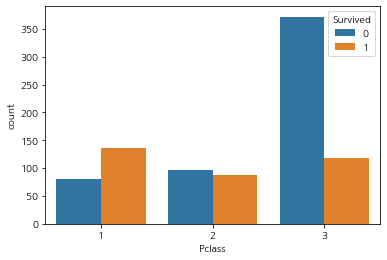

In [12]:
# Pclass(승객 등급)과 생존여부에 대하여
print(df_raw['Pclass'].value_counts())
ax = sns.countplot(x = 'Pclass', hue = 'Survived', data= df_raw)

male      577
female    314
Name: Sex, dtype: int64


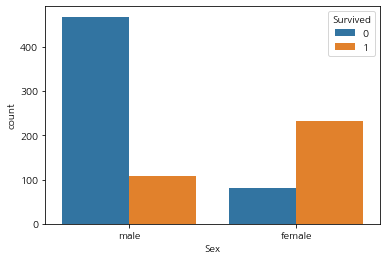

In [13]:
# 성별과 생존여부에 대하여
print(df_raw['Sex'].value_counts())
ax = sns.countplot(x='Sex', hue='Survived', data = df_raw)

30.00    202
24.00     30
22.00     27
18.00     26
28.00     25
        ... 
55.50      1
74.00      1
0.92       1
70.50      1
12.00      1
Name: Age, Length: 88, dtype: int64


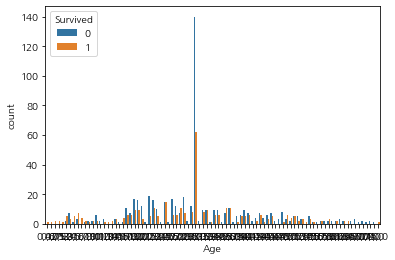

In [14]:
# 성별과 생존여부에 대하여
print(df_raw['Age'].value_counts())
ax = sns.countplot(x='Age', hue='Survived', data = df_raw)

S    646
C    168
Q     77
Name: Embarked, dtype: int64


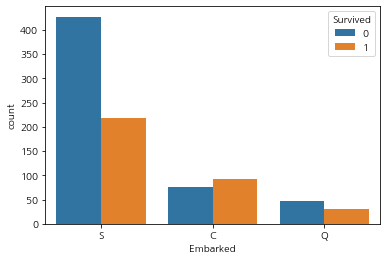

In [15]:
# 탑승장과 생존여부에 대하여
print(df_raw['Embarked'].value_counts())
ax = sns.countplot(x='Embarked', hue='Survived', data = df_raw)

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64


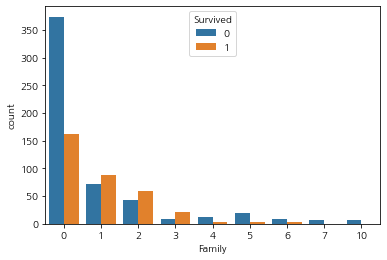

In [16]:
# 가족구성원 탑승과 생존여부에 대하여
print(df_raw['Family'].value_counts())
ax = sns.countplot(x='Family', hue='Survived', data = df_raw)

## 결과
    1. 생존에 영향을 미치지 않는다고 생각되는 변수들은 사전에 제거하였다. (PassengerId, Name, Ticket)
    2. 결측치를 50% 이상 보유하는 변수 또한 사전에 제거하였다. (Cabin)
    3. 탑승자 중 동일 가족구성원의 성격을 띄는 변수들을 하나로 묶어서 파생변수를 생성하였다. (SibSp,Parch) -> (Family)
    4. 파생변수 생성에 이용된 변수 두 개(SibSp,Parch)는 데이터가 선형성을 띄는 것을 방지하기 위해 삭제하였다.
    5. 그래프 분석을 통해 각 데이터와 생존여부 간 상관성에 대하여 분석하였다.
        ▶ Pclass(승객 등급)과 Survived(생존여부)에 대하여
            ▷ 3class을 가지는 승객들의 탑승률은 가장 높았지만, 사망률 또한 가장 높게 나왔다.
               이는 승객등급에 따른 생존율에도 차이가 있음을 유추할 수 있다.
        ▶ Sex(성별)과 Survived(생존여부)에 대하여
            ▷ 탑승객 중에서는 남성의 비율이 높았지만, 사망률도 매우 높게 나왔다. 반면에 탑승객 중 여성의 비율은 남성보다 낮았지만,
               생존률은 남성보다 높게 나왔다. 이를 통하여 "Lady First" 등의 영향을 받았을 것이라 유추 가능하다.
        ▶ Age(나이)와 Survived(생존여부)에 대하여
            ▷ 탑승객 중 30대의 비율이 가장 높게 나왔지만 사망률 또한 높게 나왔다. 하지만 영유아의 탑승률은 매우 낮았지만 대부분이
               생존함을 통해 아기와 어린 아이들은 도움을 받았음을 유추할 수 있다.
        ▶ Embarked(탑승장)와 Survived(생존여부)에 대하여
            ▷ S, C, Q 총 3가지로 탑승장이 구성되며, S 탑승장에서의 탑승객 비율이 가장 높았다. 하지만 사망률 또한 S 탑승장 탑승객들이
               가장 높게 나옴을 알 수 있다. 하지만 C 탑승장에서의 탑승객은 전부 사망했고, Q 탑승장에서의 탑승객들은 대부분이 사망했음을 
               알 수 있다. 따라서 탑승장 별 경제적 여건이나 비행기 내에서의 좌석의 위치가 생존에 영향을 미쳤다고 유추할 수 있다.
        ▶ Family(가족구성원)와 Survived(생존여부)에 대하여
            ▷ 혼자 탑승한 탑승객들의 높은 사망률을 통해, 가족구성원끼리 탑승한 탑승객들은 생존에 유리했음을 유추할 수 있다.

___ 
# <span style="color:red">문제 2</span>
- #### 목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를 생성하여 회귀분석을 실시하고 결과를 해석하라.
- #### (BMI 계산 시, WEIGHT 단위는 pound, HEIGHT 단위는 inch이므로 변환하여 사용할 것)
- #### 데이터 : 체질검사.CSV(변수: 14, 자료 수: 252개)

### 문제풀이
    1. 데이터 구성하기
       - "WEIGHT" 단위는 kg으로, "HEIGHT" 단위는 cm로 변환
       - "BMI" 파생변수 생성, WEIGHT와 HEIGHT로 구성
    2. 변수 간의 경향성 파악 : 그래프 분석
    3. 회귀 모델 생성
    4. 후진제거법을 이용한 변수 선택
    5. 결론

In [17]:
# 데이터 불러오기
df_raw = pd.read_csv('/home/piai/Dayonizzang._.r/BigData 실습/Big Data 분석/체질검사.csv', encoding='euc-kr')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [18]:
# pound => kg, inch => centimeter 변환
df_raw['WEIGHT'] = df_raw['WEIGHT'] * 0.45
df_raw['HEIGHT'] = df_raw['HEIGHT'] * 2.54
df_raw

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,31.9,74,93.3750,177.800,40.8,112.4,108.5,107.1,59.3,42.2,24.6,33.7,30.0,20.9
248,23.6,43,76.8375,171.450,37.4,103.7,89.7,94.2,58.5,39.0,24.1,33.8,28.8,18.8
249,20.9,35,73.2375,167.640,36.4,99.1,92.8,99.2,63.1,38.7,21.7,31.1,26.4,16.9
250,17.0,56,75.4875,173.990,37.4,98.6,93.0,97.0,55.4,38.8,23.2,32.4,29.7,19.0


In [19]:
# 파생변수 'BMI' 생성, 사용된 'WEIGHT', 'HEIGHT' 변수 삭제
df_raw['BMI'] = df_raw['WEIGHT'] / (df_raw['HEIGHT'] / 100)** 2
df_raw['BMI']

0      48.523870
1      23.082595
2      26.422478
3      23.838617
4      37.293165
         ...    
247    29.537049
248    26.139558
249    26.060228
250    24.935981
251    22.921460
Name: BMI, Length: 252, dtype: float64

In [20]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FAT      252 non-null    float64
 1   AGE      252 non-null    int64  
 2   WEIGHT   252 non-null    float64
 3   HEIGHT   252 non-null    float64
 4   NECK     252 non-null    float64
 5   CHEST    252 non-null    float64
 6   ABDOMEN  252 non-null    float64
 7   HIP      252 non-null    float64
 8   THIGH    252 non-null    float64
 9   KNEE     252 non-null    float64
 10  ANKLE    252 non-null    float64
 11  BICEPS   252 non-null    float64
 12  FOREARM  252 non-null    float64
 13  WRIST    252 non-null    float64
 14  BMI      252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


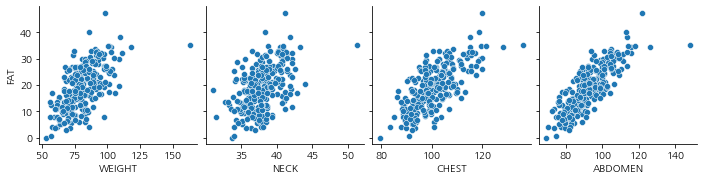

In [21]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["WEIGHT", "NECK", "CHEST", "ABDOMEN"])

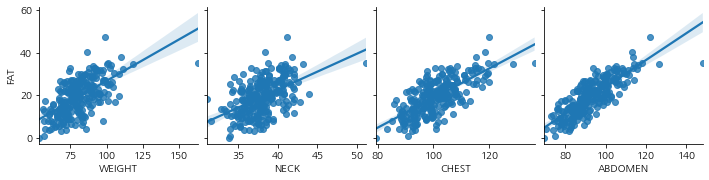

In [22]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["WEIGHT", "NECK", "CHEST", "ABDOMEN"], kind = "reg")

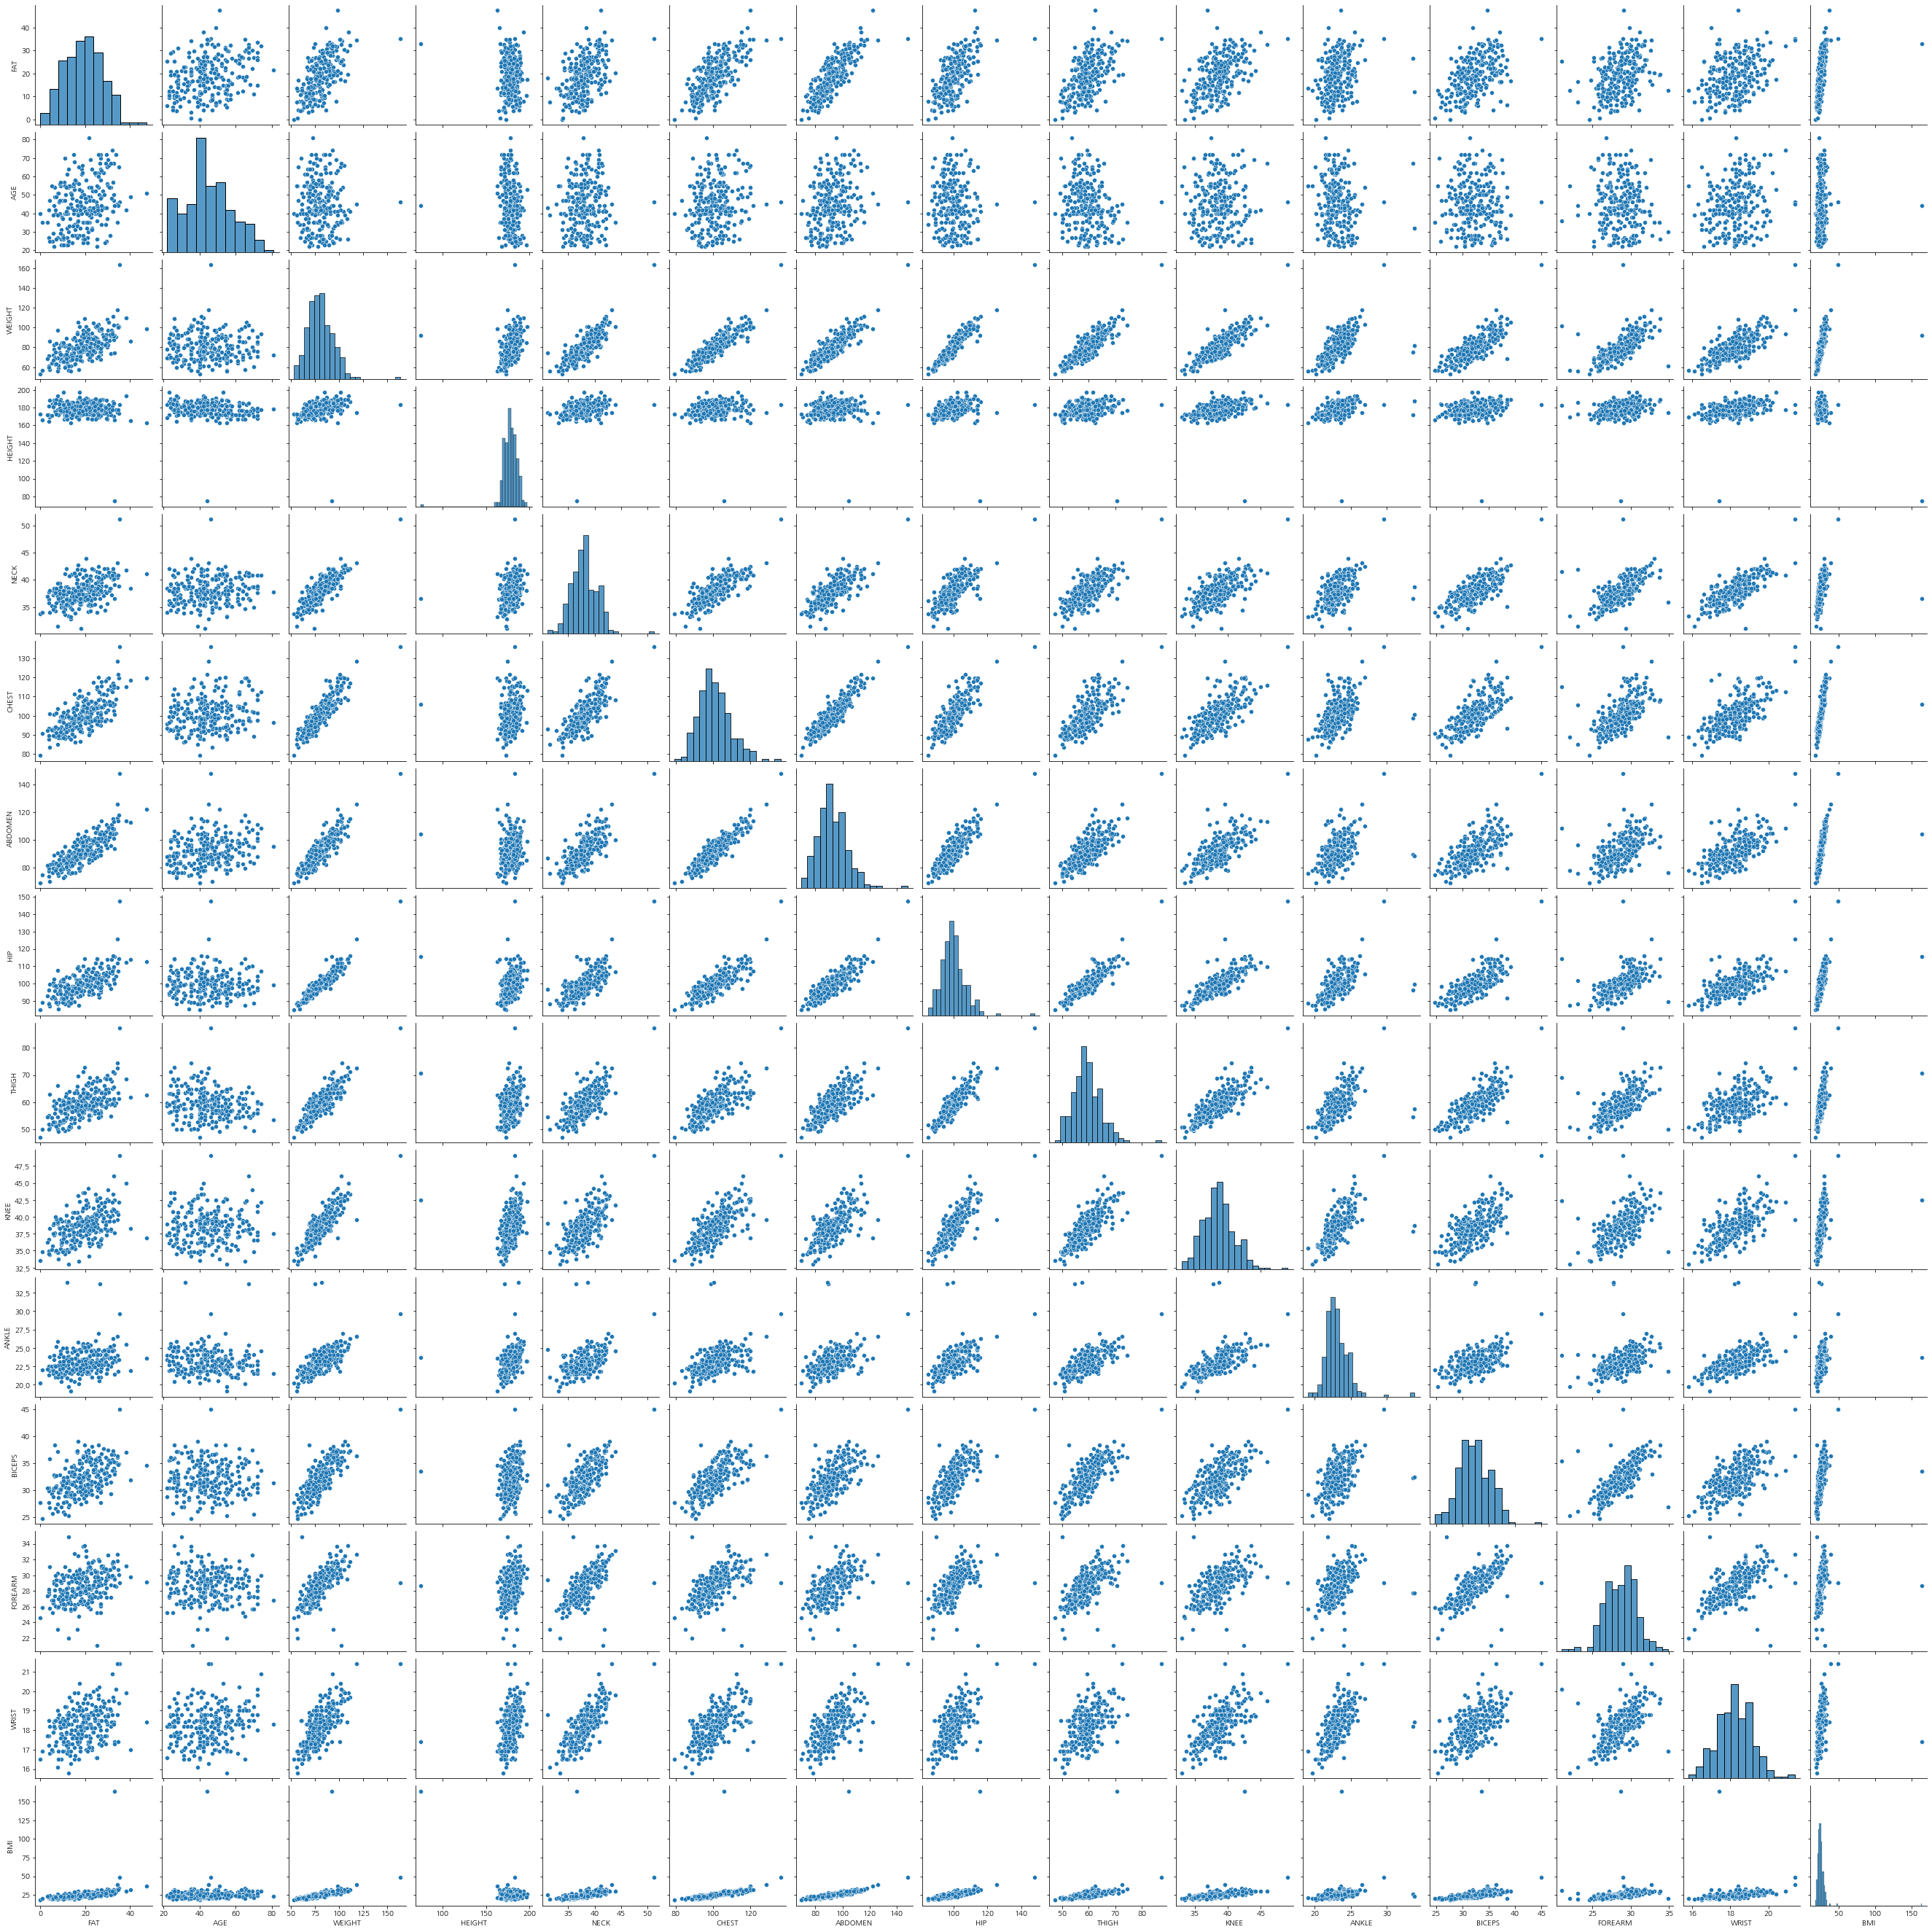

In [23]:
# 전체 변수에 대한 산점도 행렬
sns.pairplot(df_raw)

In [24]:
df_raw.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,0.371
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,0.040
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730,0.391
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322,-0.638
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.266
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,0.383
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,0.415
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,0.462
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,0.433
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,0.364


In [25]:
# 선형 회귀 분석 : formula(y ~ X1 + X2 + ...) 이용. 상수항(Intercept) 자동 추가. 코드 중간에서 줄 바꿈 “\” 추가
reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + \
                    KNEE + ANKLE + BICEPS + FOREARM + WRIST", data = df_raw)
reg_result = reg_model.fit()

print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           7.72e-64
Time:                        02:41:49   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.1885     17.349     -1.048      0.2

In [26]:
# 설명변수간의 다중공선성 확인 : 설명변수 데이터 생성 및 상수항 추가
df_raw_x = df_raw.drop("FAT", axis = 1)
# statsmodels의 상수항 추가 함수 적용
df_raw_x_const = add_constant(df_raw_x) 
# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]
# VIF 정렬
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
10,ANKLE,1.922
12,FOREARM,2.196
1,AGE,2.251
13,WRIST,3.378
11,BICEPS,3.674
4,NECK,4.456
9,KNEE,4.815
14,BMI,7.432
8,THIGH,8.010
3,HEIGHT,9.146


In [27]:
# 다중공선성 높은 변수 제거 후 공선성 재확인
df_raw_x = df_raw.drop(["FAT","WEIGHT"], axis = 1)
# statsmodels의 상수항 추가 함수 적용
df_raw_x_const = add_constant(df_raw_x) 
# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])]
# VIF 정렬
df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
9,ANKLE,1.847
11,FOREARM,2.196
1,AGE,2.196
12,WRIST,3.327
10,BICEPS,3.507
3,NECK,3.962
2,HEIGHT,4.665
13,BMI,4.729
8,KNEE,4.788
7,THIGH,7.837


In [28]:
# 선형회귀분석 : formula(y ~ X1 + X2 + ...) 이용. 상수항(Intercept) 자동 추가 + WEIGHT 제거. 줄 바꿈 “\” 추가
reg_model = smf.ols(formula = "FAT ~ AGE +  HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + \
                    KNEE + ANKLE + BICEPS + FOREARM + WRIST", data = df_raw)
# 적합
reg_result = reg_model.fit()

print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     58.55
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           3.75e-64
Time:                        02:41:49   Log-Likelihood:                -719.69
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     239   BIC:                             1511.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5453      7.672      0.984      0.3

In [29]:
# RFE(recursive feature elimination) 함수 : 입력된 모델을 이용하여 변수중요도가 낮은 순으로 순차적으로 제거
df_raw_y = df_raw["FAT"]

model = LinearRegression()
# 전체 변수 중 5개의 변수가 남을 때까지 변수 선택
rfe = RFE(estimator = model, n_features_to_select = 5).fit(df_raw_x, df_raw_y)
# 선택된 변수
selected_cols = df_raw_x.columns[rfe.support_]
# 제거된 변수
removed_cols = df_raw_x.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_cols)) 
print("Removed Variables : {}".format(removed_cols))

Selected Variables : Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables : Index(['AGE', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS', 'BMI'], dtype='object')


In [30]:
# 회귀 모델 생성
rfe_reg_model = smf.ols(formula = "FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data = df_raw)
# 적합
rfe_reg_result = rfe_reg_model.fit()

print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     133.8
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           4.38e-68
Time:                        02:41:49   Log-Likelihood:                -726.92
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     246   BIC:                             1487.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7037      6.231      0.434      0.6

In [31]:
t1 = rfe_reg_result.predict(df_raw)
tt1 = t1 - df_raw['FAT']
y1 = np.std(tt1)
y1 = y1 / 246
y1

0.017603492741501178

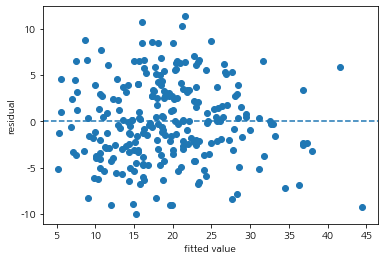

In [32]:
# 잔차 등분산성
plt.scatter(rfe_reg_result.fittedvalues, rfe_reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y = 0, linestyle = "--")

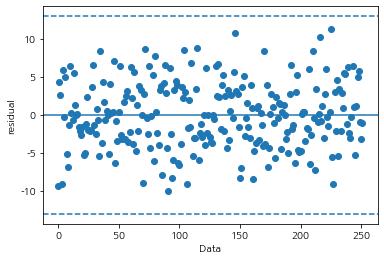

In [33]:
# 잔차의 독립성 확인
plt.scatter(df_raw.index, rfe_reg_result.resid, marker="o")
plt.xlabel("Data")
plt.ylabel("residual")
plt.axhline(y = 0, linestyle = "-")
plt.axhline(y = 3*np.std(rfe_reg_result.resid), linestyle = "--")
plt.axhline(y = -3*np.std(rfe_reg_result.resid), linestyle = "--")

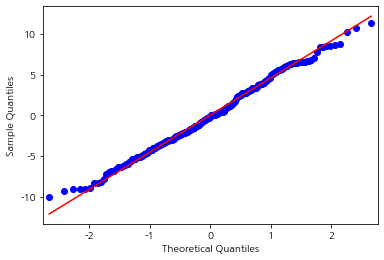

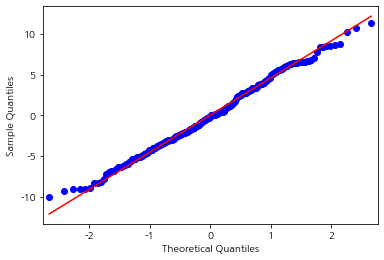

In [34]:
# 잔차 정규성 검정:Q-Q plot. s-standardized line (교재에는 없음)
#  r-regression line, q-quartiles
qqplot(rfe_reg_result.resid, line = "q")

<AxesSubplot:>

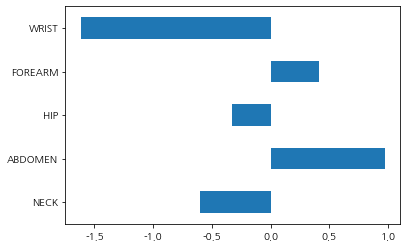

In [36]:
# 설명변수 중요도(표준화 적용 이전)  표준화 회귀계수 산출해야 함
df_reg_coef = pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y = "Coef", legend = False)

## 결과
    - 회귀식 : y = 2.7037 - 0.6012NECK + 0.9743ABDOMEN - 0.3316HIP + 0.4095FOREARM - 1.6180WRIST